# Show and Tell model training - attention based
### Based on link: https://www.tensorflow.org/tutorials/text/image_captioning

### The model architecture is similar to Show, Attend and Tell: Neural Image Caption Generation with Visual Attention.
#### Arch paper: https://arxiv.org/abs/1502.03044

# Training model on images of Coco_Train2017 dataset by splitting into Train and Test parts.

## First phase of training already done and pickled various files to resume training with the data being split in a deterministic manner.

### The encoder is pre-trained Google Inception-v3 trained on Imagenet.
### All the 118k images run through encoder already and the data is saved as .npy files. Uploaded as kaggle dataset:
### https://www.kaggle.com/pandasudipt/rohits-encodings   = 57 gb file

## AVAILABLE data :
### Coco_Train2017     = has 118287 images
### Coco_Val2017       = has 5000   images
### Combined total     = 123287     images

## USED data :
## Only 100k images of the Coco_Train2017 dataset.
### In each run, split with 95:05 = Train:Test ratio
### Kept aside 5k images for bleu scoring after model is trained

### Note: 1) Each image will have multiple captions (up to 5 as some may be discarded)
###       2) Not using the Coco_Test2017 dataset at all as it has no annotations json file which has the captions.

In [ ]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

#import collections
#import random
#import re
#from glob import glob
#from PIL import Image

In [1]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
from glob import glob
import collections
import random
import PIL
#import itertools
#import PIL.Image

## to be able to download files from output directory of kaggle
from IPython.display import FileLink

## for emailing
import smtplib
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
from email.mime.multipart import MIMEMultipart
from email.header import Header

#from zipfile import ZipFile 

In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
#!pip install -q kaggle

In [4]:
#from google.colab import drive
#drive.flush_and_unmount()
#drive.mount('/content/gdrive')

In [5]:
!ls '../'

input  lib  working


In [6]:
!ls '../input/'

coco-2017-dataset  rohits-encodings


In [7]:
!ls '../input/coco-2017-dataset/coco2017/'

annotations  test2017  train2017  val2017


In [8]:
!ls '../input/coco-2017-dataset/coco2017/annotations/'

captions_train2017.json   instances_val2017.json
captions_val2017.json	  person_keypoints_train2017.json
instances_train2017.json  person_keypoints_val2017.json


In [9]:
!ls '../input/coco-2017-dataset/coco2017/train2017/' | wc -l

118287


In [10]:
!ls '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/' | wc -l

118287


In [11]:
!ls '../working/'

__notebook_source__.ipynb


In [12]:
!mkdir '../working/weights_out/'
!mkdir '../working/chkpt_out/'
!mkdir '../working/saved_model/'

In [13]:
!ls '../working/'

__notebook_source__.ipynb  chkpt_out  saved_model  weights_out


In [14]:
!ls '../working/weights_out/'

In [15]:
!ls '/kaggle/working/weights_out/'

In [16]:
!ls '../working/chkpt_out/'

In [17]:
!ls '../working/saved_model/'

In [ ]:
#!rm -r '../working/weights_out/'

In [ ]:
#!rm -r '../working/chkpt_out/'

In [ ]:
#!rm -r '../working/saved_model/'

In [18]:
## Kaggle versions

## Weights from training till now
OPDIR = r'../working/'

## New weights to save here
OPDIR_WEIGHTS = r'../working/weights_out/'

## Training checkpoint directory
CHKPT_DIR_OUT = r'../working/chkpt_out/'

## Saved model directory
SAVED_MODEL_DIR_OUT = r'../working/saved_model/'

## Images locations
IPDIR_IMGS_COCO_TRAIN = r'../input/coco-2017-dataset/coco2017/train2017/'

## Attention model encodings saved as .npy files here for all the 118k train images
IPDIR_SAVED_ENCODINGS =  r'../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/'

## Annotations location
IPDIR_ANNO = r'../input/coco-2017-dataset/coco2017/annotations/'

## Weights from previous stage of training
#IPDIR_WEIGHTS_IN = r'pending/'

In [19]:
## VERIFY IT IS TRUE
os.path.exists(OPDIR_WEIGHTS), os.path.exists(CHKPT_DIR_OUT), os.path.exists(SAVED_MODEL_DIR_OUT), os.path.exists(IPDIR_SAVED_ENCODINGS)

(True, True, True, True)

# Prepare the data

In [20]:
PATH = os.path.abspath(IPDIR_IMGS_COCO_TRAIN) + r'/'
PATH

'/kaggle/input/coco-2017-dataset/coco2017/train2017/'

In [21]:
!ls '/kaggle/input/coco-2017-dataset/coco2017/train2017/' | wc -l

118287


In [22]:
os.path.exists(PATH + '000000044704.jpg')

True

In [23]:
IPDIR_ANNO

'../input/coco-2017-dataset/coco2017/annotations/'

In [24]:
with open(IPDIR_ANNO+'captions_train2017.json', 'r') as f:
    annotations = json.load(f)

## set MAX_IMAGES_FOR_TRAINING

In [25]:
MAX_IMAGES_FOR_TRAINING = 100000
MAX_IMAGES_FOR_TRAINING

100000

In [26]:
print(f"Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")

## Group all captions together having the same image ID.
##    Add the start and end sequence tokens at each end of existing captions


image_path_to_caption = collections.defaultdict(list)
for value in annotations['annotations']:
    caption = f"<start> {value['caption']} <end>"
    image_path = PATH + '%012d.jpg' % (value['image_id'])
    image_path_to_caption[image_path].append(caption)

print(f"End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

Start time = 07:21:48
End time = 07:21:49


In [27]:
len(image_path_to_caption)

118287

In [28]:
type(image_path_to_caption)

collections.defaultdict

In [29]:
list(image_path_to_caption.keys())[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg']

In [30]:
list(image_path_to_caption.items())[:2]

[('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000203564.jpg',
  ['<start> A bicycle replica with a clock as the front wheel. <end>',
   '<start> The bike has a clock as a tire. <end>',
   '<start> A black metal bicycle with a clock inside the front wheel. <end>',
   '<start> A bicycle figurine in which the front wheel is replaced with a clock\n <end>',
   '<start> A clock with the appearance of the wheel of a bicycle  <end>']),
 ('/kaggle/input/coco-2017-dataset/coco2017/train2017/000000322141.jpg',
  ['<start> A room with blue walls and a white sink and door. <end>',
   '<start> Blue and white color scheme in a small bathroom. <end>',
   '<start> This is a blue and white bathroom with a wall sink and a lifesaver on the wall. <end>',
   '<start> A blue boat themed bathroom with a life preserver on the wall <end>',
   '<start> A bathroom with walls that are painted baby blue. <end>'])]

In [31]:
print(f"len should be = 118287\nActual value = {len(list(image_path_to_caption.keys()))}")

len should be = 118287
Actual value = 118287


## Keep only 100k images
## Set aside 5k from this as the images to do Bleu score evaluation

In [32]:
image_paths = list(image_path_to_caption.keys())[:MAX_IMAGES_FOR_TRAINING]
print(f"Count of images used for training = {len(image_paths)}")

Count of images used for training = 100000


In [33]:
#images_5k_for_bleu_scoring = [os.path.basename(v) for v in list(image_path_to_caption.keys())[MAX_IMAGES_FOR_TRAINING : MAX_IMAGES_FOR_TRAINING+5000]]
#print(f"Count of images set aside for bleu scoring after model training = {len(images_5k_for_bleu_scoring)}")
#print(f"Few entries =\n{images_5k_for_bleu_scoring[:3]}")

### Done this already and pickled the 5k images

In [ ]:
## pickle the 5000 image filenames

# variable = images_5k_for_bleu_scoring
#with open(OPDIR+'ATTEND_images_5k_for_bleu_scoring.pkl', 'wb') as handle:
#  pickle.dump(images_5k_for_bleu_scoring, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
print(f"Expected length = {MAX_IMAGES_FOR_TRAINING}\n\nlength = {len(image_paths)}")

Expected length = 100000

length = 100000


In [35]:
random.shuffle(image_paths)
train_image_paths = image_paths

In [36]:
type(train_image_paths)

list

In [37]:
## keeping all the images, not reducing to 30k as the tutorial did
print(f"length should be = {MAX_IMAGES_FOR_TRAINING}\n\nactual value = {len(train_image_paths)}")

length should be = 100000

actual value = 100000


In [38]:
## for all images in the subset folder
train_captions = []
img_name_vector = []
for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

In [39]:
train_image_paths[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000091080.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000058075.jpg']

In [40]:
type(train_captions)

list

In [41]:
train_captions[:2]

['<start> A white refrigerator freezer sitting next to a stove top oven. <end>',
 '<start> A tea kettle that is sitting on a stove. <end>']

In [42]:
type(img_name_vector)

list

In [43]:
img_name_vector[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000091080.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000091080.jpg']

In [44]:
len(img_name_vector)

500281

<start> A white refrigerator freezer sitting next to a stove top oven. <end>


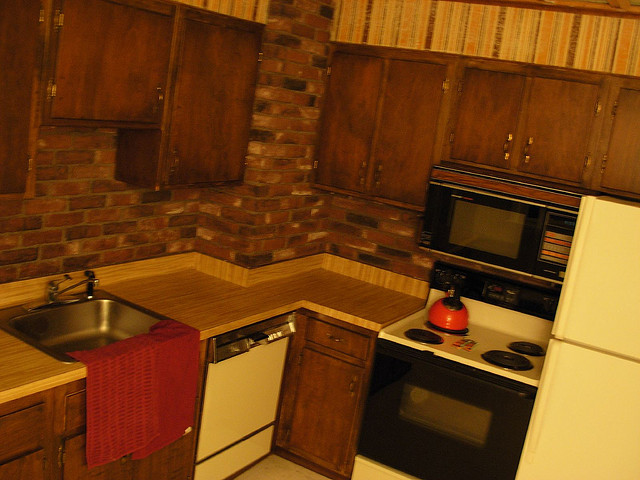

In [45]:
print(train_captions[0])
PIL.Image.open(img_name_vector[0])

# One-time Create image encodings

## Preprocess the images using InceptionV3

### Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

### First, you will convert the images into InceptionV3's expected format by:

#### Resizing the image to 299px by 299px
#### Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [ ]:
purposely written this so it fails
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights
### Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

#### You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
#### After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [ ]:
## Initialize InceptionV3 and load the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
type(image_model)

In [ ]:
IPDIR_SAVED_ENCODINGS

In [ ]:
!ls '/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/' | wc -l

In [ ]:
## check files before saving the encodings
##     folder contains only the .jpg files
len(os.listdir(IPDIR_SAVED_ENCODINGS))

In [ ]:
img_name_vector[:2]

In [ ]:
## output of this cell was:
## output starts
#Start time = 21:26:44
#path =
#b'/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000000009.jpg'
#path_of_feature =
#/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/000000000009.jpg
#bf.shape = (64, 2048)
#End time = 23:57:10
## output ends

## type(image_dataset) = tensorflow.python.data.ops.dataset_ops.BatchDataset

printflag = True
print(f"Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(4)

## now the dataset has the pre-processed img vector and its path
for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        ## now save the info to disk
        np.save(path_of_feature, bf.numpy())
        if printflag:
            print(f"path =\n{p}")
            print(f"path_of_feature =\n{path_of_feature}")
            print(f"bf.shape = {bf.shape}")
            printflag = False

print(f"End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

In [ ]:
type(image_dataset)

In [ ]:
type(encode_train)

In [ ]:
encode_train[:2]

In [ ]:
type(batch_features)

In [ ]:
batch_features[:1]

In [ ]:
batch_features[:2]

In [ ]:
## check files after saving the encodings
##     folder contains the .jpg files and its corresponding .npy file
## should be doubled i.e. 118287 * 2 = 236574
len(os.listdir(IPDIR_SAVED_ENCODINGS))

In [ ]:
!ls /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/ | head -10

In [ ]:
!ls /media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Data/COCO_train2017_118k/ | wc -l

## to compress a file
### For example, say you have a directory called /home/jerry/prog and you would like to compress this directory then you can type tar command as follows:
### tar -zcvf prog-1-jan-2005.tar.gz /home/jerry/prog

## to extract a file
### If you wish to restore your archive then you need to use the following command (it will extract all files in current directory):
### tar -zxvf prog-1-jan-2005.tar.gz

In [ ]:
#!tar -zcvf '../working/saved_encodings_TRAIN.tar.gz' '../working/saved_encodings_TRAIN'

# Preprocess and tokenize the captions

### First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
### Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
### You then create word-to-index and index-to-word mappings.
### Finally, you pad all sequences to be the same length as the longest one.

In [46]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [47]:
train_captions[:2]

['<start> A white refrigerator freezer sitting next to a stove top oven. <end>',
 '<start> A tea kettle that is sitting on a stove. <end>']

In [48]:
len(train_captions)

500281

In [49]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [50]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [51]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [52]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [53]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
print(f"max_length = {max_length}")

max_length = 52


In [54]:
## Setting max_length to 52 as that was the length in the full 118k data
max_length = 52
max_length

52

In [55]:
OPDIR

'../working/'

In [ ]:
## ONE-TIME-ONLY

## pickle the tokenizer for use during inference stage later on

# variable tokenizer
#with open(OPDIR + 'tokenizer_from_training_100k.pickle', 'wb') as handle:
#    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
#print(f"Pickled tokenizer")

## Split the data into training and testing

### used split ratio of 95:5
### For total whatever count of images in this subset
#### Total         data points = len(img_name_vector)
#### Train         data points = train % ratio
#### Test          data points = test  % ratio

In [56]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 95-05 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.95)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [57]:
len(img_name_vector), len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(500281, 475263, 475263, 25018, 25018)

In [58]:
len(img_to_cap_vector)

100000

In [59]:
img_name_train[:2]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000184889.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000184889.jpg']

In [60]:
cap_train[:2]

[array([  3,   2,  37,   6, 474, 246,   8,  44,   6,   2,  33,   4,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       dtype=int32),
 array([   3,  284, 1196,    9,  114,  218,    5,    2,   33,  483,    4,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)]

# Create a tf.data dataset for training

### Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [61]:
len(img_name_train)

475263

In [62]:
img_name_train[:3]

['/kaggle/input/coco-2017-dataset/coco2017/train2017/000000184889.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000184889.jpg',
 '/kaggle/input/coco-2017-dataset/coco2017/train2017/000000184889.jpg']

In [63]:
type(img_name_train)

list

In [64]:
IPDIR_SAVED_ENCODINGS

'../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/'

In [65]:
## current img_name_train points to the actual .jpg file location.
## Original code expects the .npy file of the saved encoding to also be here - but this is not so in my use case
## so create new list with entries pointing to the encodings location
img_name_train_correct_enc_locs = [IPDIR_SAVED_ENCODINGS + os.path.basename(val) for val in img_name_train]

In [66]:
len(img_name_train_correct_enc_locs)

475263

In [67]:
img_name_train_correct_enc_locs[:3]

['../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000184889.jpg',
 '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000184889.jpg',
 '../input/rohits-encodings/media/rohit/DATA/EverythingD/01SRHBDBA_Acads/Thesis/StoryGenerator/Code/ModelsRuns/ImgCapAttention/SavedData/Thesis_ImgCapATTENTION_saved_encodings_TRAIN_118k/000000184889.jpg']

In [68]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 128
BUFFER_SIZE = 250
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [69]:
num_steps

3712

In [70]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [71]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train_correct_enc_locs, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model
### Fun fact: the decoder below is identical to the one in the example for Neural Machine Translation with Attention (https://www.tensorflow.org/tutorials/sequences/nmt_with_attention).

### The model architecture is inspired by the Show, Attend and Tell paper (https://arxiv.org/pdf/1502.03044.pdf).

### In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
### You squash that to a shape of (64, 2048).
### This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
### The RNN (here GRU) attends over the image to predict the next word.

In [72]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [73]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [74]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [75]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [76]:
type(encoder)

__main__.CNN_Encoder

In [77]:
type(decoder)

__main__.RNN_Decoder

In [78]:
optimizer = tf.keras.optimizers.Adam()

In [80]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [81]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# Checkpoint

In [82]:
CHKPT_DIR_OUT

'../working/chkpt_out/'

In [83]:
checkpoint_path = CHKPT_DIR_OUT
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [84]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Training

### You extract the features stored in the respective .npy files and then pass those features through the encoder.
### The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
### The decoder returns the predictions and the decoder hidden state.
### The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
### Use teacher forcing to decide the next input to the decoder.
### Teacher forcing is the technique where the target word is passed as the next input to the decoder.
### The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [85]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [86]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    
    total_loss = (loss / int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [87]:
OPDIR_WEIGHTS

'../working/weights_out/'

In [88]:
os.listdir(OPDIR_WEIGHTS)

[]

In [89]:
def send_email_NO_zip(_inFile, _epoch):
    sender = 'xxx' # your email address
    receivers = ['xxx','xxx']
    mail_host = 'smtp.gmail.com' # check your email provider's doc

    # email and passwd
    mail_user = 'xxx' # your email address
    mail_pass = 'xxxx' # password

    # email
    message = MIMEMultipart()
    message['To'] =  Header('self', 'utf-8') # receive's name, optional
    message['Subject'] = Header(f'Weights Zip file - ep_{_epoch}', 'utf-8') # email subject
    message.attach(MIMEText('New weights file', 'plain', 'utf-8')) # email body

    # attachment
    att1 = MIMEApplication(open(_inFile, 'rb').read())
    att1.add_header('Content-Disposition', 'attachment', filename=os.path.basename(_inFile))
    # att1['Content-Type'] = 'application/octet-stream'
    # att1["Content-Disposition"] = 'attachment; filename="simnet.pt"'
    message.attach(att1)

    try:
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.ehlo()
        server.starttls()
        server.ehlo()
        server.login(mail_user, mail_pass)
        server.sendmail(sender, receivers, message.as_string())
        server.quit()
        print(f'\nEMAIL SUCCESS - for epoch {_epoch}\n')
    except smtplib.SMTPException as e_SMPTException:
        print(f'\nEMAIL FAILED - SMTPException - for epoch {_epoch}\n{e_SMPTException}\n')
    except Exception as e_unknown:
        print(f'\nEMAIL FAILED - Unknown - for epoch {_epoch}\n{e_unknown}\n')

In [90]:
start_epoch

0

In [91]:
print(f"Using learning rate = {optimizer.learning_rate.numpy()}")

Using learning rate = 0.0010000000474974513


In [ ]:
EPOCHS = 20

print(f"Training Start time = {datetime.datetime.now().strftime('%H:%M:%S')}")
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1000 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 1 == 0:
        ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    ## save the weights
    new_weights_file = OPDIR_WEIGHTS + 'ATTEND_Decoder_wts_ep_' + str(epoch) + '.h5'
    decoder.save_weights( new_weights_file )
    print(f"""\nSaved weights for epoch {epoch} to:\n{new_weights_file}\n""")
    send_email_NO_zip(new_weights_file, epoch)

print(f"Training End time = {datetime.datetime.now().strftime('%H:%M:%S')}")

Training Start time = 07:23:58
Epoch 1 Batch 0 Loss 1.8278
Epoch 1 Batch 1000 Loss 0.6619
Epoch 1 Batch 2000 Loss 0.6780
Epoch 1 Batch 3000 Loss 0.6088
Epoch 1 Loss 0.681300
Time taken for 1 epoch 1398.9130482673645 sec


Saved weights for epoch 0 to:
../working/weights_out/ATTEND_Decoder_wts_ep_0.h5


EMAIL SUCCESS - for epoch 0

Epoch 2 Batch 0 Loss 0.6061
Epoch 2 Batch 1000 Loss 0.5746
Epoch 2 Batch 2000 Loss 0.6007
Epoch 2 Batch 3000 Loss 0.5830
Epoch 2 Loss 0.590444
Time taken for 1 epoch 1337.541874885559 sec


Saved weights for epoch 1 to:
../working/weights_out/ATTEND_Decoder_wts_ep_1.h5


EMAIL SUCCESS - for epoch 1

Epoch 3 Batch 0 Loss 0.5523
Epoch 3 Batch 1000 Loss 0.6112
Epoch 3 Batch 2000 Loss 0.5818
Epoch 3 Batch 3000 Loss 0.5446
Epoch 3 Loss 0.565615
Time taken for 1 epoch 1370.633472919464 sec


Saved weights for epoch 2 to:
../working/weights_out/ATTEND_Decoder_wts_ep_2.h5


EMAIL SUCCESS - for epoch 2

Epoch 4 Batch 0 Loss 0.5487
Epoch 4 Batch 1000 Loss 0.5929
Epoch 

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
optimizer.learning_rate.numpy()

In [ ]:
decoder.summary()

In [ ]:
decoder.attention.summary()